In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
df_all = pd.read_csv('/content/drive/MyDrive/urdu/ab/train.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f433190a250>,
      dtype=object)

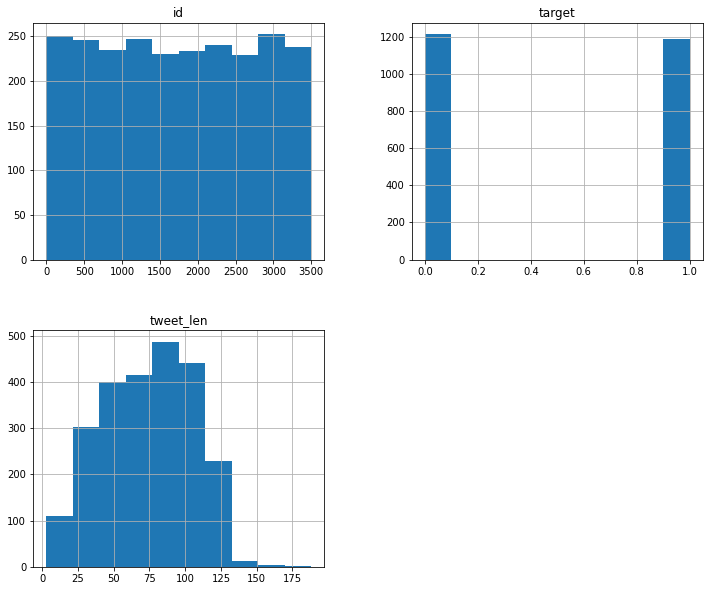

In [ ]:
df_all['tweet_len'] = df_all.tweet.apply(len)
df_all.hist(figsize=(12,10))

In [ ]:
df_all.tweet_len.describe()

count    2400.000000
mean       73.315000
std        30.903053
min         3.000000
25%        48.000000
50%        75.000000
75%        99.000000
max       188.000000
Name: tweet_len, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split
df, df_holdout = train_test_split(df_all, test_size=0.2, shuffle=False)

In [ ]:
df

,id,tweet,target,tweet_len
0,1024,قوم کے لیے پرانے خاندانی نمک حرام ہیں,1,38
1,1919,اور پھر بھی ان خنزیروں کو بغض نواز میں سپورٹ ک...,0,68
2,102,پاکستان کے قبضے میں اسرائیلی پائلٹ ہے۔,0,38
3,679,اور نواز شریف کا نواسہ مستقبل کا وزیر اعظم,0,43
4,2093,صرف ٹویٹر پہ بکواس کرنا ہی آسان ہے,0,35
...,...,...,...,...
1915,969,او کھوتے خور پٹواری یہ جس کی تصویریں لگا کر ت...,0,105
1916,2643,لو جی کشمیر ہمارا گیا شہ رگ ہماری کٹی تکلیف ہم...,0,113
1917,2685,اپنی گند اٹھاؤ رنڈی کے بچے بہن چود بھڑوے,1,43
1918,1375,کسی گشتی کے بچے کسے کتے کی آوارہ اولاد مادر چو...,1,54


In [ ]:
!pip install transformers
!pip install datasets

     |████████████████████████████████| 2.6 MB 12.7 MB/s 
     |████████████████████████████████| 636 kB 42.8 MB/s 
     |████████████████████████████████| 895 kB 43.5 MB/s 
     |████████████████████████████████| 3.3 MB 46.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 264 kB 13.3 MB/s 
     |████████████████████████████████| 118 kB 48.3 MB/s 
     |████████████████████████████████| 243 kB 51.8 MB/s 


In [ ]:
import os
import gc

from tqdm import tqdm
import json
from pprint import pprint

import math
import numpy as np

from transformers import AutoModel, AutoConfig, AutoTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
import datasets

model_name = 'bert-base-multilingual-uncased'
bert_config = AutoConfig.from_pretrained(model_name)
bert_config.num_labels=2
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_inputs = ["input_ids", "attention_mask", "token_type_ids"]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

In [ ]:
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
accuracy_metric = datasets.load_metric("accuracy")
f1_metric = datasets.load_metric("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        **accuracy_metric.compute(predictions=predictions, references=labels),
        **f1_metric.compute(predictions=predictions, references=labels),
    }

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

In [ ]:
from sklearn.model_selection import KFold
from transformers.trainer_utils import EvalPrediction
kfold = KFold(n_splits=5, shuffle=False)
accuracy = []
f1 = []
for train_idx, test_idx in kfold.split(df):
  !rm -rf ./urdu_trainer/*
  inputs_train = { **bert_tokenizer(df.iloc[train_idx].tweet.values.tolist(),
                         return_tensors="pt",
                         truncation=True,
                         padding=True
                         ), "label": df.iloc[train_idx].target.values}
  X_train = datasets.Dataset.from_dict(inputs_train)
  inputs_test = {**bert_tokenizer(df.iloc[test_idx].tweet.values.tolist(),
                         return_tensors="pt",
                         truncation=True,
                         padding=True
                         ), "label": df.iloc[test_idx].target.values}
  X_test = datasets.Dataset.from_dict(inputs_test)
  training_args = TrainingArguments("urdu_trainer",
                                  evaluation_strategy="steps",
                                  load_best_model_at_end=True,
                                  metric_for_best_model="accuracy",
                                  eval_steps=16,
                                  save_steps=16,
                                  num_train_epochs=6,
                                  per_device_train_batch_size=32,
                                  per_device_eval_batch_size=32,
                                  save_total_limit=10)
  bert = BertForSequenceClassification.from_pretrained(model_name, config=bert_config)
  bert.to(device)
  trainer = Trainer(
      model=bert,
      args=training_args,
      train_dataset=X_train,
      eval_dataset=X_test,
      compute_metrics=compute_metrics
  )
  
  trainer.train()

  with torch.no_grad():        
    outputs = bert(**{k: v.to(device) for k, v in inputs_test.items() if k != "label"}).logits.cpu().numpy()
    eval_pred = EvalPrediction(predictions=outputs, label_ids=np.array(inputs_test["label"]))
    metrics = compute_metrics(eval_pred)
    accuracy.append(metrics["accuracy"])
    f1.append(metrics["f1"])

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading weights file https://huggingface.co/bert-base-multilingual-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/37f730c9dc4fc13ab6bf412fdc0ad936241a39a70628c2d4a85a607ea775b865.a458b2dad7b293099dd815628e032e6c22519889d75f13d6f244dbe068525a56
Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dens

Step,Training Loss,Validation Loss,Accuracy,F1
16,No log,0.619168,0.643229,0.718686
32,No log,0.492820,0.789062,0.776860
48,No log,0.449372,0.809896,0.801090
64,No log,0.418628,0.794271,0.794805
80,No log,0.416059,0.815104,0.808625
96,No log,0.595022,0.796875,0.757764
112,No log,0.563449,0.825521,0.804665
128,No log,0.413312,0.835938,0.832000
144,No log,0.531094,0.822917,0.825641
160,No log,0.549193,0.830729,0.827586


***** Running Evaluation *****
  Num examples = 384
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-16
Configuration saved in urdu_trainer/checkpoint-16/config.json
Model weights saved in urdu_trainer/checkpoint-16/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 384
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-32
Configuration saved in urdu_trainer/checkpoint-32/config.json
Model weights saved in urdu_trainer/checkpoint-32/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 384
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-48
Configuration saved in urdu_trainer/checkpoint-48/config.json
Model weights saved in urdu_trainer/checkpoint-48/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 384
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-64
Configuration saved in urdu_trainer/checkpoint-64/config.json
Model weights saved in urdu_trainer/checkpoint-64/py

Step,Training Loss,Validation Loss,Accuracy,F1
16,No log,0.688761,0.497396,0.030151
32,No log,0.515181,0.770833,0.809524
48,No log,0.434682,0.815104,0.811671
64,No log,0.366127,0.833333,0.841584
80,No log,0.409546,0.856771,0.866180
96,No log,0.380025,0.851562,0.862651
112,No log,0.460546,0.848958,0.858537
128,No log,0.394849,0.843750,0.857143
144,No log,0.426144,0.856771,0.868735
160,No log,0.411780,0.841146,0.850123


***** Running Evaluation *****
  Num examples = 384
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-16
Configuration saved in urdu_trainer/checkpoint-16/config.json
Model weights saved in urdu_trainer/checkpoint-16/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 384
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-32
Configuration saved in urdu_trainer/checkpoint-32/config.json
Model weights saved in urdu_trainer/checkpoint-32/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 384
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-48
Configuration saved in urdu_trainer/checkpoint-48/config.json
Model weights saved in urdu_trainer/checkpoint-48/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 384
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-64
Configuration saved in urdu_trainer/checkpoint-64/config.json
Model weights saved in urdu_trainer/checkpoint-64/py

Step,Training Loss,Validation Loss,Accuracy,F1
16,No log,0.559343,0.742188,0.759124
32,No log,0.580773,0.778646,0.808126
48,No log,0.344532,0.875000,0.881188
64,No log,0.303663,0.882812,0.884319
80,No log,0.333999,0.864583,0.856354
96,No log,0.393314,0.815104,0.830549
112,No log,0.408257,0.872396,0.871391
128,No log,0.415807,0.833333,0.850467
144,No log,0.339179,0.856771,0.862155
160,No log,0.460765,0.854167,0.851852


***** Running Evaluation *****
  Num examples = 384
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-16
Configuration saved in urdu_trainer/checkpoint-16/config.json
Model weights saved in urdu_trainer/checkpoint-16/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 384
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-32
Configuration saved in urdu_trainer/checkpoint-32/config.json
Model weights saved in urdu_trainer/checkpoint-32/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 384
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-48
Configuration saved in urdu_trainer/checkpoint-48/config.json
Model weights saved in urdu_trainer/checkpoint-48/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 384
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-64
Configuration saved in urdu_trainer/checkpoint-64/config.json
Model weights saved in urdu_trainer/checkpoint-64/py

Step,Training Loss,Validation Loss,Accuracy,F1
16,No log,0.563977,0.721354,0.747045
32,No log,0.387110,0.864583,0.857143
48,No log,0.428454,0.820312,0.831296
64,No log,0.426017,0.830729,0.817927
80,No log,0.433721,0.856771,0.846797


***** Running Evaluation *****
  Num examples = 384
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-16
Configuration saved in urdu_trainer/checkpoint-16/config.json
Model weights saved in urdu_trainer/checkpoint-16/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 384
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-32
Configuration saved in urdu_trainer/checkpoint-32/config.json
Model weights saved in urdu_trainer/checkpoint-32/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 384
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-48
Configuration saved in urdu_trainer/checkpoint-48/config.json
Model weights saved in urdu_trainer/checkpoint-48/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 384
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-64
Configuration saved in urdu_trainer/checkpoint-64/config.json
Model weights saved in urdu_trainer/checkpoint-64/py

Step,Training Loss,Validation Loss,Accuracy,F1
16,No log,0.563977,0.721354,0.747045
32,No log,0.387110,0.864583,0.857143
48,No log,0.428454,0.820312,0.831296
64,No log,0.426017,0.830729,0.817927
80,No log,0.433721,0.856771,0.846797
96,No log,0.371784,0.830729,0.837093
112,No log,0.428294,0.864583,0.860215
128,No log,0.483400,0.794271,0.812352
144,No log,0.389493,0.856771,0.855643
160,No log,0.446050,0.861979,0.854795


***** Running Evaluation *****
  Num examples = 384
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-96
Configuration saved in urdu_trainer/checkpoint-96/config.json
Model weights saved in urdu_trainer/checkpoint-96/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 384
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-112
Configuration saved in urdu_trainer/checkpoint-112/config.json
Model weights saved in urdu_trainer/checkpoint-112/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 384
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-128
Configuration saved in urdu_trainer/checkpoint-128/config.json
Model weights saved in urdu_trainer/checkpoint-128/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 384
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-144
Configuration saved in urdu_trainer/checkpoint-144/config.json
Model weights saved in urdu_trainer/checkpoi

Step,Training Loss,Validation Loss,Accuracy,F1
16,No log,0.622279,0.755208,0.763819
32,No log,0.542502,0.804688,0.823529
48,No log,0.454416,0.817708,0.830097
64,No log,0.435655,0.794271,0.800000
80,No log,0.545095,0.804688,0.827586
96,No log,0.459823,0.786458,0.814480
112,No log,0.492761,0.835938,0.844444
128,No log,0.382945,0.825521,0.836186
144,No log,0.449907,0.828125,0.841346
160,No log,0.446573,0.830729,0.843373


***** Running Evaluation *****
  Num examples = 384
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-16
Configuration saved in urdu_trainer/checkpoint-16/config.json
Model weights saved in urdu_trainer/checkpoint-16/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 384
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-32
Configuration saved in urdu_trainer/checkpoint-32/config.json
Model weights saved in urdu_trainer/checkpoint-32/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 384
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-48
Configuration saved in urdu_trainer/checkpoint-48/config.json
Model weights saved in urdu_trainer/checkpoint-48/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 384
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-64
Configuration saved in urdu_trainer/checkpoint-64/config.json
Model weights saved in urdu_trainer/checkpoint-64/py

In [ ]:
f"accuracy: {(np.mean(accuracy), np.std(accuracy))} \n f1: {(np.mean(f1), np.std(f1))}"

'accuracy: (0.859375, 0.013681172433920512) \n f1: (0.8596662918164523, 0.016203429267924566)'

In [ ]:
from transformers.trainer_utils import EvalPrediction
!rm -rf ./urdu_trainer/*
inputs_all_train = { **bert_tokenizer(df.tweet.values.tolist(),
                        return_tensors="pt",
                        truncation=True,
                        padding=True
                        ), "label": df.target.values}
X_all_train = datasets.Dataset.from_dict(inputs_all_train)
inputs_holdout = {**bert_tokenizer(df_holdout.tweet.values.tolist(),
                        return_tensors="pt",
                        truncation=True,
                        padding=True
                        ), "label": df_holdout.target.values}
X_holdout = datasets.Dataset.from_dict(inputs_holdout)

In [ ]:
training_args_final = TrainingArguments("urdu_trainer",
                                evaluation_strategy="steps",
                                load_best_model_at_end=True,
                                metric_for_best_model="f1",
                                eval_steps=4,
                                save_steps=4,
                                num_train_epochs=3,
                                per_device_train_batch_size=32,
                                per_device_eval_batch_size=32,
                                save_total_limit=15)

bert_final = BertForSequenceClassification.from_pretrained(model_name, config=bert_config)
bert_final.to(device)
trainer_final = Trainer(
    model=bert_final,
    args=training_args_final,
    train_dataset=X_all_train,
    eval_dataset=X_holdout,
    compute_metrics=compute_metrics
)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [ ]:
trainer_final.train()

***** Running training *****
  Num examples = 1920
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 180


Step,Training Loss,Validation Loss,Accuracy,F1
4,No log,0.664024,0.670833,0.622010
8,No log,0.577533,0.718750,0.693878
12,No log,0.538173,0.756250,0.764588
16,No log,0.506998,0.756250,0.783734
20,No log,0.514677,0.779167,0.790514
24,No log,0.487069,0.797917,0.802444
28,No log,0.450335,0.802083,0.828210
32,No log,0.433909,0.806250,0.822180
36,No log,0.536408,0.756250,0.724706
40,No log,0.461322,0.822917,0.842884


***** Running Evaluation *****
  Num examples = 480
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-4
Configuration saved in urdu_trainer/checkpoint-4/config.json
Model weights saved in urdu_trainer/checkpoint-4/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 480
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-8
Configuration saved in urdu_trainer/checkpoint-8/config.json
Model weights saved in urdu_trainer/checkpoint-8/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 480
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-12
Configuration saved in urdu_trainer/checkpoint-12/config.json
Model weights saved in urdu_trainer/checkpoint-12/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 480
  Batch size = 32
Saving model checkpoint to urdu_trainer/checkpoint-16
Configuration saved in urdu_trainer/checkpoint-16/config.json
Model weights saved in urdu_trainer/checkpoint-16/pytorch_

TrainOutput(global_step=180, training_loss=0.3440178977118598, metrics={'train_runtime': 1931.6036, 'train_samples_per_second': 2.982, 'train_steps_per_second': 0.093, 'total_flos': 227919951705600.0, 'train_loss': 0.3440178977118598, 'epoch': 3.0})

In [ ]:
with torch.no_grad():        
  outputs = bert_final(**{k: v.to(device) for k, v in inputs_holdout.items() if k != "label"}).logits.cpu().numpy()
  eval_pred = EvalPrediction(predictions=outputs, label_ids=np.array(inputs_holdout["label"]))
  metrics_final = compute_metrics(eval_pred)
  print(f"accuracy final: {metrics_final['accuracy']} \nf1 final\t: {metrics_final['f1']}")

accuracy final: 0.8541666666666666 
f1 final	: 0.8653846153846153


In [ ]:
df_test_final = pd.read_csv('/content/drive/MyDrive/urdu/ab/test.csv')
inputs_test_final = {**bert_tokenizer(df_test_final.tweet.values.tolist(),
                        return_tensors="pt",
                        truncation=True,
                        padding=True
                        )}

In [ ]:
from scipy.special import softmax
np.set_printoptions(precision=5)
with torch.no_grad():        
  outputs = bert_final(**{k: v.to(device) for k, v in inputs_test_final.items()}).logits.cpu().numpy()

In [ ]:
from pprint import pprint
import sys
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
predictions = np.argmax(outputs, axis=-1)

In [ ]:
score = softmax(outputs, axis=-1)

In [ ]:
df_test_final['target'] = predictions
df_test_final['score'] = score[:, 1]
df_test_final

,id,tweet,target,score
0,3024,آپ نے ان سے سوال نہیں کیا کہ پرانے پاکستان می...,0,0.058649
1,3235,گُل بُخاری گشتی تھی گشتی ھے گشتی رھے گی کر لو...,1,0.968449
2,2227,منافرت پھیلانے ،ھڈی پر نظر رکھنےّ،مرمٹنے،زلیل...,0,0.010803
3,2659,جس کسی نے دنیا کا سب سے بڑا بہن چود بیغرت دیکھ...,1,0.968727
4,1311,ظالم بدمعاش ریاست,1,0.637042
...,...,...,...,...
1095,2928,بیغیرتوں لعنت ہے تم پر تم جزبہ خیر سگالی پالو ...,1,0.772285
1096,1928,تیری گانڈ مارے بندہ اور رونے بھی نہ دے,1,0.888795
1097,1931,بیرون ملک رہنے والے غیر ملکیوں کے دلے پاکستان ...,0,0.310860
1098,1798,یہ گشتی عورت جس طرح بھونک رہی ہے کتیا کی طرح ک...,1,0.955477


In [ ]:
df_test_final[['id', 'target', 'score']].to_csv('/content/drive/MyDrive/urdu/ab/submission.csv', index=False)